In [4]:
import numpy as np
import os

import pandas as pd

%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split)
from sklearn.feature_selection import RFECV

from sklearn.svm import SVC

import joblib

from libs.container import Container
import dataset

In [5]:
cpu = joblib.cpu_count()

In [3]:
data = dataset.load_scaled()

df = pd.concat([data.b278, data.b261])

cls = {name: idx for idx, name in enumerate(df.tile.unique())}
df["cls"] = df.tile.apply(cls.get)

print(cls)

del data

Reading '/mnt/is0/jbcabral/denoise/dataset/full_scaled.pkl.bz2'
{'b278': 0, 'b261': 1}


In [2]:
sel = joblib.load("results/rfecv.pkl.bz2")

In [35]:
resume = {"Feature": dataset.FEATURES}
for key, clf in sel.items():
    key = "-".join(key)
    print(f"[{key}] Selected Features: ", clf.support_.sum())
    resume.update({
        f"{key} Selected": clf.support_, 
        f"{key} Ranking": clf.ranking_, 
        f"{key} Score": clf.grid_scores_})
resume.keys()

rdf = pd.DataFrame(resume)
rdf = rdf.reset_index(drop=True)

rdf["Mean Score"] = rdf[rdf.columns[rdf.columns.str.endswith(" Score")]].mean(axis=1)
rdf["Selected N"] = rdf[rdf.columns[rdf.columns.str.endswith(" Selected")]].sum(axis=1)

[b261-b277] Selected Features:  14
[b261-b278] Selected Features:  30
[b261-b360] Selected Features:  2
[b277-b278] Selected Features:  21
[b277-b360] Selected Features:  9
[b278-b360] Selected Features:  2


In [68]:
list(sorted(rdf["Mean Score"].values))

[0.5236594335451854,
 0.8367705162402953,
 0.9044945650707011,
 0.9049289494047391,
 0.9049901876440224,
 0.9049991526106252,
 0.9052081039445107,
 0.9052467098439738,
 0.9055097295197965,
 0.9055359124835816,
 0.9058489610325439,
 0.9063979595454592,
 0.9094885758076793,
 0.9128569400836364,
 0.9132306242499043,
 0.9137566821279699,
 0.91401076876057,
 0.9140239619226543,
 0.9140394618291633,
 0.9142571201741383,
 0.9142571903507694,
 0.9142656733721798,
 0.9143286075306215,
 0.9143311642646036,
 0.9143811155335616,
 0.9143955113334151,
 0.9144206329689122,
 0.9144418433016331,
 0.9144672627504198,
 0.9145447953280481,
 0.9146015868173428,
 0.914707196315179,
 0.9147818287745925,
 0.9147827681214157,
 0.914819985658421,
 0.9148458037468227,
 0.9148474505997962,
 0.9149054117946309,
 0.9150428192709734,
 0.915087116176812,
 0.9152175743017769,
 0.9153977561435235,
 0.915519288937985,
 0.9155959332825735,
 0.9156761773496469,
 0.9156792299219495,
 0.9157354053054093,
 0.9157798424951981

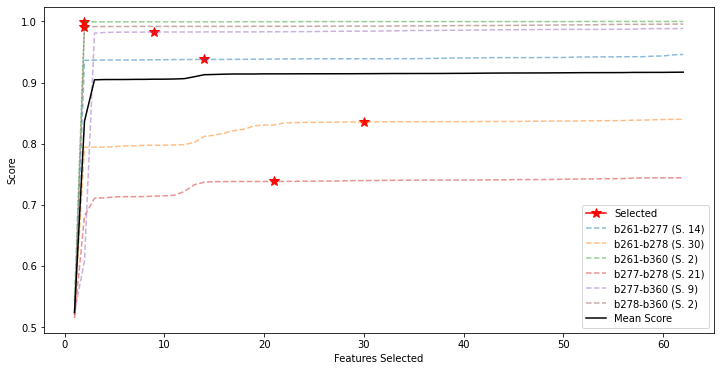

In [93]:
fig, ax = plt.subplots(figsize=(12, 6))

selected_label = "Selected"
for key  in sel.keys():
    key = "-".join(key)
    scores = sorted(rdf[f"{key} Score"].values)
    selected = rdf[f"{key} Selected"].sum()
    
    label = f"{key} (S. {selected})"
    
    ax.plot(selected, scores[selected], color="r", marker="*", markersize=10, label=selected_label)
    ax.plot(range(1, len(scores) + 1), scores, alpha=.5, ls="--", label=label)
    
    selected_label = "_no_label_"
    

label = f"Mean Score"
plt.plot(range(1, len(scores) + 1), sorted(rdf["Mean Score"].values), label=label, color="k")
    
ax.set_xlabel("Features Selected")
ax.set_ylabel("Score")




# plt.plot(range(1, len(sel.grid_scores_) + 1), sel.grid_scores_)
# plt.axvline(selected, c="r", alpha=0.5, ls="--", label=f"Features óptimos ({selected})")
plt.legend()
# plt.tight_layout()
# plt.savefig("plots/rfe.pdf")
plt.show()

{1: array([0.267004, 0.004874, 0.329415, 1.      ]),
 2: array([0.26851 , 0.009605, 0.335427, 1.      ]),
 3: array([0.269944, 0.014625, 0.341379, 1.      ]),
 4: array([0.271305, 0.019942, 0.347269, 1.      ]),
 5: array([0.272594, 0.025563, 0.353093, 1.      ]),
 6: array([0.273809, 0.031497, 0.358853, 1.      ])}

In [135]:
colors = {
    6: "#ccebc5",
    4: "#b3cde3",
    3: "#decbe4",
    2: "#ffffcc",
    
    1: "#fbb4ae",   
}

def color_selected(row):
    color = colors.get(row["Selected N"])
    if color is not None:
        return pd.Series(f'background-color: {color}; color: black', row.index)
    
    return pd.Series('', row.index)

html = rdf[rdf.columns[(
    rdf.columns.str.endswith(" Selected") | 
    rdf.columns.str.startswith("Feature") |
    rdf.columns.str.startswith("Selected N"))]
].sort_values("Selected N", ascending=False).style.apply(color_selected, axis=1)

html

,Feature,b261-b277 Selected,b261-b278 Selected,b261-b360 Selected,b277-b278 Selected,b277-b360 Selected,b278-b360 Selected,Selected N
56,n09_hk_color,True,True,True,True,True,True,6
50,c89_hk_color,True,True,True,True,True,True,6
53,c89_m2,True,True,False,True,True,False,4
60,n09_m4,True,True,False,True,True,False,4
59,n09_m2,True,True,False,True,True,False,4
57,n09_jh_color,True,True,False,True,True,False,4
54,c89_m4,True,True,False,True,True,False,4
51,c89_jh_color,True,True,False,True,True,False,4
58,n09_jk_color,True,True,False,True,False,False,3
55,n09_c3,True,True,False,True,False,False,3


In [7]:
def is_selected(row):
    if row.Selected:
        return pd.Series('background-color: #7EA489', row.index)
    return pd.Series('', row.index)


with pd.option_context('display.precision', 4):
    html = rdf.sort_values("Ranking").style.apply(is_selected, axis=1)
html

,Feature,Selected,Ranking
0,Amplitude,True,1
34,Mean,True,1
36,MedianBRP,True,1
38,PercentAmplitude,True,1
39,PercentDifferenceFluxPercentile,True,1
43,Psi_eta,True,1
44,Q31,True,1
45,Rcs,True,1
48,Std,True,1
50,c89_hk_color,True,1


In [8]:
X = df[dataset.FEATURES].values
y = df.cls.values
sel.score(X, y)

0.8645

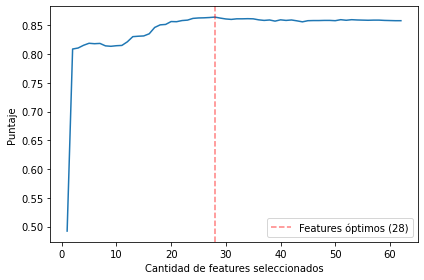

In [9]:
plt.figure()
plt.xlabel("Cantidad de features seleccionados")
plt.ylabel("Puntaje")
plt.plot(range(1, len(sel.grid_scores_) + 1), sel.grid_scores_)
plt.axvline(selected, c="r", alpha=0.5, ls="--", label=f"Features óptimos ({selected})")
plt.legend()
plt.tight_layout()
plt.savefig("plots/rfe.pdf")
plt.show()

In [10]:
sX_columns = rdf[rdf.Selected].Feature.values
joblib.dump(sX_columns, "results/rfe_features.pkl.bz2", compress=3)
sX_columns

array(['Amplitude', 'Autocor_length', 'Eta_e', 'FluxPercentileRatioMid50',
       'FluxPercentileRatioMid65', 'Freq1_harmonics_amplitude_0',
       'Freq1_harmonics_amplitude_1', 'Freq1_harmonics_amplitude_2',
       'LinearTrend', 'Mean', 'MedianBRP', 'PercentAmplitude',
       'PercentDifferenceFluxPercentile', 'Psi_eta', 'Q31', 'Rcs', 'Std',
       'c89_hk_color', 'c89_jh_color', 'c89_jk_color', 'c89_m2', 'c89_m4',
       'n09_c3', 'n09_hk_color', 'n09_jh_color', 'n09_jk_color', 'n09_m2',
       'n09_m4'], dtype=object)

In [11]:
nX_columns = rdf[~rdf.Selected].Feature.values
joblib.dump(nX_columns, "results/not_rfe_features.pkl.bz2", compress=3)
nX_columns

array(['Beyond1Std', 'Con', 'FluxPercentileRatioMid20',
       'FluxPercentileRatioMid35', 'FluxPercentileRatioMid80',
       'Freq1_harmonics_amplitude_3', 'Freq1_harmonics_rel_phase_1',
       'Freq1_harmonics_rel_phase_2', 'Freq1_harmonics_rel_phase_3',
       'Freq2_harmonics_amplitude_0', 'Freq2_harmonics_amplitude_1',
       'Freq2_harmonics_amplitude_2', 'Freq2_harmonics_amplitude_3',
       'Freq2_harmonics_rel_phase_1', 'Freq2_harmonics_rel_phase_2',
       'Freq2_harmonics_rel_phase_3', 'Freq3_harmonics_amplitude_0',
       'Freq3_harmonics_amplitude_1', 'Freq3_harmonics_amplitude_2',
       'Freq3_harmonics_amplitude_3', 'Freq3_harmonics_rel_phase_1',
       'Freq3_harmonics_rel_phase_2', 'Freq3_harmonics_rel_phase_3',
       'Gskew', 'MaxSlope', 'MedianAbsDev', 'PairSlopeTrend', 'PeriodLS',
       'Period_fit', 'Psi_CS', 'Skew', 'SmallKurtosis', 'c89_c3', 'ppmb'],
      dtype=object)

In [12]:
def execute_kfold(clf_name, clasificator, sample,  X_columns, y_column, nfolds):
    
    skf = StratifiedKFold(n_splits=nfolds)
    
    X = sample[X_columns].values
    y = sample[y_column].values
    
    probabilities = None
    predictions = np.array([])
    y_tests = np.array([])
    
    for train, test in skf.split(X, y):
        x_train = X[train]
        y_train = y[train]
        x_test = X[test]
        y_test = y[test]
        
        clf = sklearn.clone(clasificator)
        clf.fit(x_train, y_train)
        
        current_pred = clf.predict(x_test)
        current_prob = clf.predict_proba(x_test)
        
        y_tests = np.hstack([y_tests, y_test])
        predictions = np.hstack([predictions, current_pred])
        probabilities = (
                current_prob if probabilities is None else
                np.vstack([probabilities, current_prob ]))
            
    fpr, tpr, thresholds = metrics.roc_curve(
        y_tests, 1.-probabilities[:,0], pos_label=1)
    prec_rec_curve = metrics.precision_recall_curve(
        y_tests, 1.- probabilities[:,0], pos_label=1)
    
    roc_auc = metrics.auc(fpr, tpr)
    
    print(metrics.classification_report(y_tests, predictions))
    print("-" * 80)
    
    result = Container({
        "clf_name": clf_name,
        "nfolds": nfolds,
        'fpr': fpr,
        'tpr': tpr,
        'thresh': thresholds,
        'roc_auc': roc_auc,
        'prec_rec_curve': prec_rec_curve,
        'real_cls': y_tests,
        'predictions': predictions,
        'probabilities': probabilities,
        'confusion_matrix': metrics.confusion_matrix(y_tests, predictions)})    
    return result

In [13]:
%%time

BEST_PARAMS = joblib.load("results/hp_selection.pkl.bz2")
SVC_LINEAR_PARAMS = BEST_PARAMS["svc_linear"].best_params_

del BEST_PARAMS

SVC_LINEAR_PARAMS

fname = "results/rfe_clf.pkl.bz2"
if os.path.exists(fname):
    rfe_clf  = Container(joblib.load(fname))
else:
    rfe_clf = execute_kfold(
        clf_name="SVM-Linear", 
        clasificator=SVC(**SVC_LINEAR_PARAMS), 
        sample=df, X_columns=sX_columns, y_column="cls", nfolds=10)
    joblib.dump(dict(rfe_clf), fname, compress=3)
rfe_clf["clf_name"] = "RFE"
rfe_clf["clf_name"]

CPU times: user 1.72 s, sys: 34.5 ms, total: 1.76 s
Wall time: 1.78 s


'RFE'

In [20]:
%%time

BEST_PARAMS = joblib.load("results/hp_selection.pkl.bz2")
SVC_LINEAR_PARAMS = BEST_PARAMS["svc_linear"].best_params_

del BEST_PARAMS

SVC_LINEAR_PARAMS

fname = "results/not_rfe_clf.pkl.bz2"
if os.path.exists(fname):
    not_rfe_clf  = Container(joblib.load(fname))
else:
    not_rfe_clf = execute_kfold(
        clf_name="SVM-Linear", 
        clasificator=SVC(**SVC_LINEAR_PARAMS), 
        sample=df, X_columns=nX_columns, y_column="cls", nfolds=10)
    joblib.dump(dict(not_rfe_clf), fname, compress=3)
not_rfe_clf["clf_name"] = "Not-RFE"
not_rfe_clf["clf_name"]

              precision    recall  f1-score   support

         0.0       0.61      0.53      0.57      2000
         1.0       0.58      0.65      0.62      2000

    accuracy                           0.59      4000
   macro avg       0.60      0.59      0.59      4000
weighted avg       0.60      0.59      0.59      4000

--------------------------------------------------------------------------------
CPU times: user 2h 20min 40s, sys: 175 ms, total: 2h 20min 40s
Wall time: 2h 20min 41s


'Not-RFE'

In [21]:
clf = Container(joblib.load("results/model_selection.pkl.bz2")[0])
clf["clf_name"] = "All features"
clf["clf_name"]

'All features'

In [24]:
results = [rfe_clf, not_rfe_clf, clf]

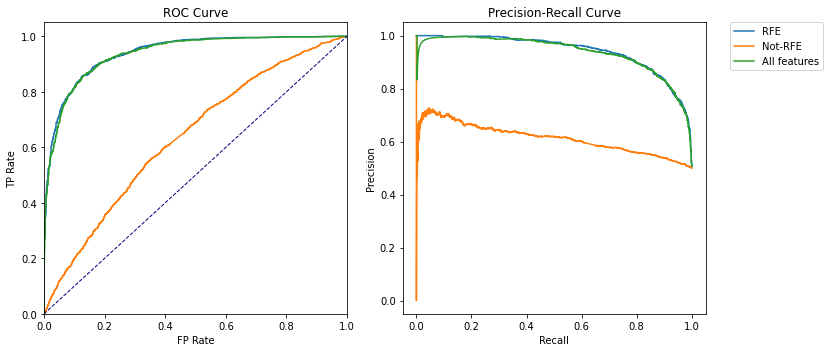

In [25]:
def roc(results, ax=None, labels=True):
    if ax == None:
        ax = plt.gca()

    for res in results:
        cname = "{}".format(res.clf_name)
        label = res.clf_name if labels else "_no_legend_"
        ax.plot(res["fpr"], res["tpr"],  label=label)

    ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('FP Rate')
    ax.set_ylabel('TP Rate')
    ax.set_title('ROC Curve')
    
    return ax


def prc(results, ax=None, labels=True):
    if ax == None:
        ax = plt.gca()
        
    for r in results:
        label = r.clf_name if labels else "_no_legend_"
        ax.plot(r.prec_rec_curve[1], r.prec_rec_curve[0], label=label)
        
    ax.set_title("Precision-Recall Curve")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
roc(results, ax=ax[0])
prc(results, ax=ax[1], labels=False)

lgd = fig.legend(bbox_to_anchor=(1.15, 0.93))
fig.tight_layout();

fig.savefig("plots/rfe_curve.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [26]:
rows = []
for r in results:
    prec = metrics.precision_score(r.real_cls, r.predictions)
    rec = metrics.recall_score(r.real_cls, r.predictions)
    rows.append({"Model": r.clf_name, "Precision": prec, "Recall": rec, "AUC": r.roc_auc})
resume = pd.DataFrame(rows)
resume

,Model,Precision,Recall,AUC
0,RFE,0.846485,0.8850,0.940551
1,Not-RFE,0.584375,0.6545,0.635492
2,All features,0.842584,0.8805,0.937774


In [ ]:
print(resume.to_latex(index=False, float_format="%.3f"))